In [77]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [78]:
%cd /content/drive/MyDrive/cs/cs171/project

/content/drive/MyDrive/cs/cs171/project


In [79]:
pwd

'/content/drive/MyDrive/cs/cs171/project'

In [80]:
!find /content/drive/MyDrive -type d -name "audio"


/content/drive/MyDrive/cs/cs171/project/audio


In [81]:
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt


In [82]:
wav_path = "/content/drive/MyDrive/cs/cs171/project/audio/LOV3_Sik_K.wav"

sr, data = wavfile.read(wav_path)

print("Sample rate:", sr) # 샘플링 레이트는 여기서 초당 몇번 사진을 찍느냐

# 1khz 가 초당 1000번
print("Shape:", data.shape)


Sample rate: 44100
Shape: (10418176, 2)


In [83]:
print("Dtype:", data.dtype)

Dtype: int16


In [84]:
print("Min value:", data.min())

Min value: -32768


In [85]:
print("Max value:", data.max())

Max value: 32767


In [86]:
print("Mean abs value:", np.mean(np.abs(data)))

Mean abs value: 9444.05832258929


In [87]:
# Convert stereo to mono
# 스테레오는 소리가 두 줄로 존재하는 것 (L,R 즉 양쪽에서 사운드가 들리는 것임) 근데 우리는 분석을 하기에 양쪽에서 사운드가 불필요함. 그래서 모노로 변환 해서 수치만 따는거 (분석에 필요한 한 줄)

if len(data.shape) == 2:
    mono = data.mean(axis=1) # L과 R 두 값을 평균 내서 하나의 숫자로 만들었다는 뜻
else:
    mono = data

print("Mono shape:", mono.shape)

# wav 파일들은 소리 = 숫자들의 리스트(?) 라고 할 수 있다. 즉, 소리들이 스피커 기준으로 아주 빠르게 앞 뒤로 움직여서 소리를 만듦.
# 양수면 스피커 앞, 음수면 스피커 뒤, 예를들어 0 이라면 무음이라는 뜻



Mono shape: (10418176,)


In [88]:
print("First 10 samples:", mono[:10]) # sanity check

# 즉 44100개중에서 10개만 정상 체크 한 것임.
# 많은 곡들이 0.1~0.2 초 정도는 조용하게 시작하는 곡들이 많음, 그래서 10개 샘플 값이 다 0

First 10 samples: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [89]:
print(mono[10000:10100])

[ -4735.   -4361.5  -4191.   -4341.   -4341.   -3819.   -3669.5  -4789.
  -6701.   -8409.   -9308.5  -9133.   -8001.5  -6578.   -5662.5  -5313.5
  -4932.   -4364.   -4006.5  -4110.   -4686.   -5428.   -5793.   -5739.5
  -5850.5  -6464.   -6992.   -6628.   -5836.5  -5808.5  -6611.5  -7667.
  -8746.   -9409.   -9461.   -9502.5  -9733.   -9744.5  -9590.5  -9728.
 -10197.  -10487.  -10605.5 -11221.5 -11827.5 -11415.5 -10851.  -10959.
 -10715.  -10010.  -10102.  -10959.  -11633.5 -11838.5 -11774.5 -11782.
 -11849.  -11553.5 -11041.5 -10892.  -11193.  -11792.  -12636.5 -13382.5
 -13603.  -13466.5 -13418.5 -13471.5 -13598.5 -13846.  -13792.5 -13477.5
 -13629.  -13765.  -13112.5 -12712.  -13055.  -12817.  -12010.5 -11756.
 -11557.5 -10741.5  -9973.5  -9567.5  -9054.5  -8341.5  -7813.   -7620.
  -7331.5  -6888.5  -7175.   -8261.5  -9006.   -9113.5  -8990.   -8416.5
  -7489.5  -6857.5  -6218.5  -4820. ]


In [90]:
# 1) 현재 모노 데이터의 최대 절댓값 확인
max_abs = np.max(np.abs(mono))
print("Max abs before normalization:", max_abs)

# 2) -1 ~ 1 사이로 정규화
mono_norm = mono / max_abs

# 곡 마다 천차만별인 모노값 정규화


Max abs before normalization: 32768.0


In [91]:
# 2) -1 ~ 1 사이로 정규화
mono_norm = mono / max_abs

print("Min after normalization:", mono_norm.min())

Min after normalization: -1.0


In [92]:
print("Max after normalization:", mono_norm.max())

Max after normalization: 0.999969482421875


In [93]:
print("First 10 samples after normalization:", mono_norm[:10])

First 10 samples after normalization: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [94]:
# time axis for the whole audio (in seconds)
duration = len(mono_norm) / sr  # 여기서는 전체 샘플 개수 / 초당 샘플 개수 이렇게 해서 총 노래가 총 몇 초 인지

print("Duration (seconds):", duration)

t = np.arange(len(mono_norm)) / sr


Duration (seconds): 236.23981859410432


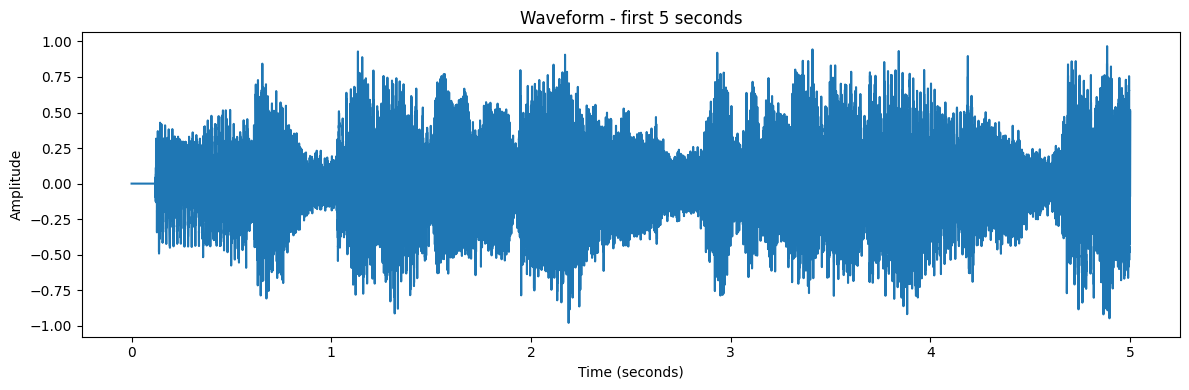

In [95]:
seconds = 5  # show first 5 seconds

# 그냥 sanity check 해본거임. 여기서 5초는 의미가 있는건 아니고 잘 뽑혔나 테스팅 정도?

end_sample = int(seconds * sr)

plt.figure(figsize=(12, 4))
plt.plot(t[:end_sample], mono_norm[:end_sample])
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title(f"Waveform - first {seconds} seconds")
plt.tight_layout()
plt.show()


In [96]:
# 우리 30초만 뽑아볼거니까 여기서 한번 설정을 줘보도록 해볼게.

analysis_seconds = 30

analysis_end_sample = int(analysis_seconds * sr)

# 소리를 엄청 빠르게 잘게 잘라서 숫자 하나씩 저장하는겨. 이것이 점이고 샘플임.
# 초 * 샘플레이트 (sr 요건 위에 나옴) = 그 시간 동안에 들어있는 점의 개수. 쉽게말해 우리가 설정한 시간 동안에 들어있는 데이터의 개수라고 생각하면 됨.

mono_30 = mono_norm[:analysis_end_sample]

# 30초 만큼 떼어서 momo30에 저장

t_30 = np.arange(len(mono_30)) / sr

# 이건 각 샘플이 몇 초 위치인지를 나타내는 시간축 배열을 만듦


In [97]:
print("30-sec shape:", mono_30.shape)
print("30-sec duration (sec):", len(mono_30) / sr) # 샘플 개수를 다시 초로 변환


30-sec shape: (1323000,)
30-sec duration (sec): 30.0


In [98]:
# Spectrogram

# 스펙트로그램 할때도 확실히 하려고 다시 찍고
mono_30 = mono_norm[:analysis_end_sample]

# STFT settings (Short Time Fourier Transform의 줄임말임)
# 쉽게 말해서 그냥 소리를 짧게 잘라서 잘린 조각마다 주파수 분석을 하는 방법 (예를들어 음악용 초고속 현미경? 느낌)

n_fft = 2048          # 아까 위에서 짧게 잘라서 분석한다고 했잖아, 그거의 한 덩어리의 크기여. 그니까 2048개의 샘플이 한 개로 취급하는거임 이제부터.
                      # 그리고 2048은 시간정보와 주파수정보의 균형이 최고인 값이라 표준처럼 쓰는 값

hop_length = 512      # 적절한 예 인지는 모르겠는데 파노라마 사진 찍을때 원리가.. 내가 알기로는 아마 천천히 여러사진들이 겹치면서 넓게 나타나는거거든?
                      # 이것도 비슷한 원리야. 그니까 스펙트로그램이 부드럽게 나타나려면 덩어리들이 부분적으로 겹쳐있어야 돼. 그렇게 되어야 끊기지 않고 자연스럽게 연결 된다고 생각하면 돼.
                      # 그럼 512 인 이유는 보통 한 덩어리의 75% 정도를 오버랩 시키는게 표준비율이야 (황금비율 ㅇㅇ)
                      # 정확하게 말해, 1~2048 이 한덩어리라면 다음 덩어리는 512~2559 까지가 그 다음 덩어리. 이런식으로 부드러운 스펙트로그램 만드는 원리임.

window = np.hanning(n_fft)  # STFT 할 때 소리를 2048를 하나의 덩어리로 보잖아? 근데 그냥 뚝 잘라서 FFT 하면, 덩어리의 양 끝이 갑자기 끊기면서 주파수 결과에 가짜 잡음이 생김
                            # Hanning window: 자르기 전에 양 끝을 테이프로 살짝 눌러 부드럽게 만든 다음 자르는 느낌
